In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
import random
from makemore import PytorchifiedBatchNorm, Linear, Tanh, BatchNorm1d, load_words

%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
train_words, dev_words, test_words = load_words()

In [6]:
pytorchified = PytorchifiedBatchNorm([200], batchnorm_output=False)

In [7]:
lossi, ud = pytorchified.train(train_words)

Epoch 0 Loss: 2.4064336891319904
Epoch 1 Loss: 2.2949224881151933
Epoch 2 Loss: 2.2631975756044618
Epoch 3 Loss: 2.24538444230213
Epoch 4 Loss: 2.2315133992026284
Epoch 5 Loss: 2.222514262072223
Epoch 6 Loss: 2.21617734444771
Epoch 7 Loss: 2.2087419089946354
Epoch 8 Loss: 2.203415830044563
Epoch 9 Loss: 2.2000580487240406
Epoch 10 Loss: 2.1970888651511316
Epoch 11 Loss: 2.193447718412798
Epoch 12 Loss: 2.1912938745675703
Epoch 13 Loss: 2.188144867828926
Epoch 14 Loss: 2.1855567170979997
Epoch 15 Loss: 2.18325033953868
Epoch 16 Loss: 2.1808309601699913
Epoch 17 Loss: 2.180187302966937
Epoch 18 Loss: 2.1783067406970464
Epoch 19 Loss: 2.1762382246189147
Epoch 20 Loss: 2.175381190673492
Learning rate reduced to 0.01
Epoch 21 Loss: 2.1116246351925483
Epoch 22 Loss: 2.107380926012888
Epoch 23 Loss: 2.10675815909259
Epoch 24 Loss: 2.105317740047955
Epoch 25 Loss: 2.104704157974369
Epoch 26 Loss: 2.103552217963788
Epoch 27 Loss: 2.103643615092284
Epoch 28 Loss: 2.1034142854946247
Epoch 29 Loss

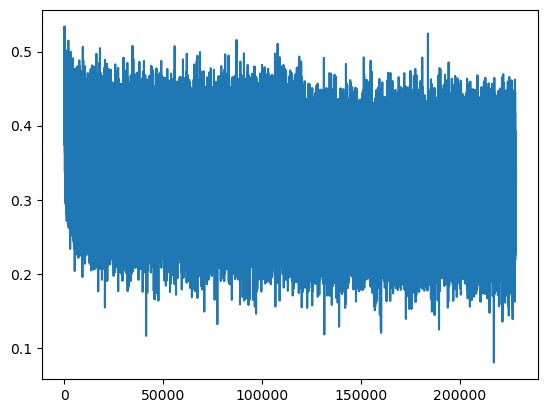

In [8]:
plt.plot(lossi)

In [9]:
print(pytorchified.evaluate(dev_words))
print(pytorchified.evaluate(test_words))

2.1103482246398926
2.105882406234741


In [10]:
for _ in range(20):
    print(pytorchified.forward())

gode
girmin
akel
alson
illity
khalorian
clini
rairo
knio
demonalury
laycitte
nor
deza
jalik
ladd
zereasobelriya
jeem
alan
amora
oslyn
